In [2]:
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer, KNNImputer, MissingIndicator
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder, MinMaxScaler, PowerTransformer, OrdinalEncoder
from sklearn.model_selection import train_test_split

In [ ]:
%pip install mlflow dagshub

In [3]:
import dagshub
dagshub.init(repo_owner='prathamshelke2903', repo_name='Swiggy_Delivery_Time_Prediction', mlflow=True)

Accessing as prathamshelke2903

Initialized MLflow to track repo "prathamshelke2903/Swiggy_Delivery_Time_Prediction"

Repository prathamshelke2903/Swiggy_Delivery_Time_Prediction initialized!

In [4]:
import mlflow

In [5]:
# set the tracking server

mlflow.set_tracking_uri("https://dagshub.com/prathamshelke2903/Swiggy_Delivery_Time_Prediction.mlflow")

In [6]:
# mlflow experiment

mlflow.set_experiment("Exp 5 - RF HP Tuning")

2025/06/28 18:37:37 INFO mlflow.tracking.fluent: Experiment with name 'Exp 5 - RF HP Tuning' does not exist. Creating a new experiment.


<Experiment: artifact_location='mlflow-artifacts:/31af11027f524a5a8c812fa354b9ba54', creation_time=1751116057263, experiment_id='4', last_update_time=1751116057263, lifecycle_stage='active', name='Exp 5 - RF HP Tuning', tags={}>

In [7]:
from sklearn import set_config

set_config(transform_output="pandas")

# Loading Cleaned Data

In [8]:
# load the cleaned data

df = pd.read_csv('/Users/prathamshelke/Desktop/EndToEndProjects/Swiggy_Delivery_Time_Prediction/swiggy_dataset/swiggy_cleaned.csv')

df

,rider_id,age,ratings,restaurant_latitude,restaurant_longitude,delivery_latitude,delivery_longitude,order_date,weather,traffic,...,city_name,order_day,order_month,order_day_of_week,is_weekend,pickup_time_minutes,order_time_hour,order_time_of_day,distance,distance_type
0,INDORES13DEL02,37.0,4.9,22.745049,75.892471,22.765049,75.912471,2022-03-19,sunny,high,...,INDO,19,3,saturday,1,15.0,11.0,morning,3.025149,short
1,BANGRES18DEL02,34.0,4.5,12.913041,77.683237,13.043041,77.813237,2022-03-25,stormy,jam,...,BANG,25,3,friday,0,5.0,19.0,evening,20.183530,very_long
2,BANGRES19DEL01,23.0,4.4,12.914264,77.678400,12.924264,77.688400,2022-03-19,sandstorms,low,...,BANG,19,3,saturday,1,15.0,8.0,morning,1.552758,short
3,COIMBRES13DEL02,38.0,4.7,11.003669,76.976494,11.053669,77.026494,2022-04-05,sunny,medium,...,COIMB,5,4,tuesday,0,10.0,18.0,evening,7.790401,medium
4,CHENRES12DEL01,32.0,4.6,12.972793,80.249982,13.012793,80.289982,2022-03-26,cloudy,high,...,CHEN,26,3,saturday,1,15.0,13.0,afternoon,6.210138,medium
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45497,JAPRES04DEL01,30.0,4.8,26.902328,75.794257,26.912328,75.804257,2022-03-24,windy,high,...,JAP,24,3,thursday,0,10.0,11.0,morning,1.489846,short
45498,AGRRES16DEL01,21.0,4.6,NaN,NaN,NaN,NaN,2022-02-16,windy,jam,...,AGR,16,2,wednesday,0,15.0,19.0,evening,NaN,NaN
45499,CHENRES08DEL03,30.0,4.9,13.022394,80.242439,13.052394,80.272439,2022-03-11,cloudy,low,...,CHEN,11,3,friday,0,15.0,23.0,night,4.657195,short
45500,COIMBRES11DEL01,20.0,4.7,11.001753,76.986241,11.041753,77.026241,2022-03-07,cloudy,high,...,COIMB,7,3,monday,0,5.0,13.0,afternoon,6.232393,medium


In [9]:
df.columns

Index(['rider_id', 'age', 'ratings', 'restaurant_latitude',
       'restaurant_longitude', 'delivery_latitude', 'delivery_longitude',
       'order_date', 'weather', 'traffic', 'vehicle_condition',
       'type_of_order', 'type_of_vehicle', 'multiple_deliveries', 'festival',
       'city_type', 'time_taken', 'city_name', 'order_day', 'order_month',
       'order_day_of_week', 'is_weekend', 'pickup_time_minutes',
       'order_time_hour', 'order_time_of_day', 'distance', 'distance_type'],
      dtype='object')

In [10]:
# drop columns not required for model input

columns_to_drop =  ['rider_id',
                    'restaurant_latitude',
                    'restaurant_longitude',
                    'delivery_latitude',
                    'delivery_longitude',
                    'order_date',
                    "order_time_hour",
                    "order_day",
                    "city_name",
                    "order_day_of_week",
                    "order_month"]

df.drop(columns=columns_to_drop, inplace=True)

df

,age,ratings,weather,traffic,vehicle_condition,type_of_order,type_of_vehicle,multiple_deliveries,festival,city_type,time_taken,is_weekend,pickup_time_minutes,order_time_of_day,distance,distance_type
0,37.0,4.9,sunny,high,2,snack,motorcycle,0.0,no,urban,24,1,15.0,morning,3.025149,short
1,34.0,4.5,stormy,jam,2,snack,scooter,1.0,no,metropolitian,33,0,5.0,evening,20.183530,very_long
2,23.0,4.4,sandstorms,low,0,drinks,motorcycle,1.0,no,urban,26,1,15.0,morning,1.552758,short
3,38.0,4.7,sunny,medium,0,buffet,motorcycle,1.0,no,metropolitian,21,0,10.0,evening,7.790401,medium
4,32.0,4.6,cloudy,high,1,snack,scooter,1.0,no,metropolitian,30,1,15.0,afternoon,6.210138,medium
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45497,30.0,4.8,windy,high,1,meal,motorcycle,0.0,no,metropolitian,32,0,10.0,morning,1.489846,short
45498,21.0,4.6,windy,jam,0,buffet,motorcycle,1.0,no,metropolitian,36,0,15.0,evening,NaN,NaN
45499,30.0,4.9,cloudy,low,1,drinks,scooter,0.0,no,metropolitian,16,0,15.0,night,4.657195,short
45500,20.0,4.7,cloudy,high,0,snack,motorcycle,1.0,no,metropolitian,26,0,5.0,afternoon,6.232393,medium


In [11]:
# check for missing values

df.isna().sum()

age                    1854
ratings                1908
weather                 525
traffic                 510
vehicle_condition         0
type_of_order             0
type_of_vehicle           0
multiple_deliveries     993
festival                228
city_type              1198
time_taken                0
is_weekend                0
pickup_time_minutes    1640
order_time_of_day      2070
distance               3630
distance_type          3630
dtype: int64

In [12]:
# check for duplicates

df.duplicated().sum()

np.int64(0)

<Axes: >

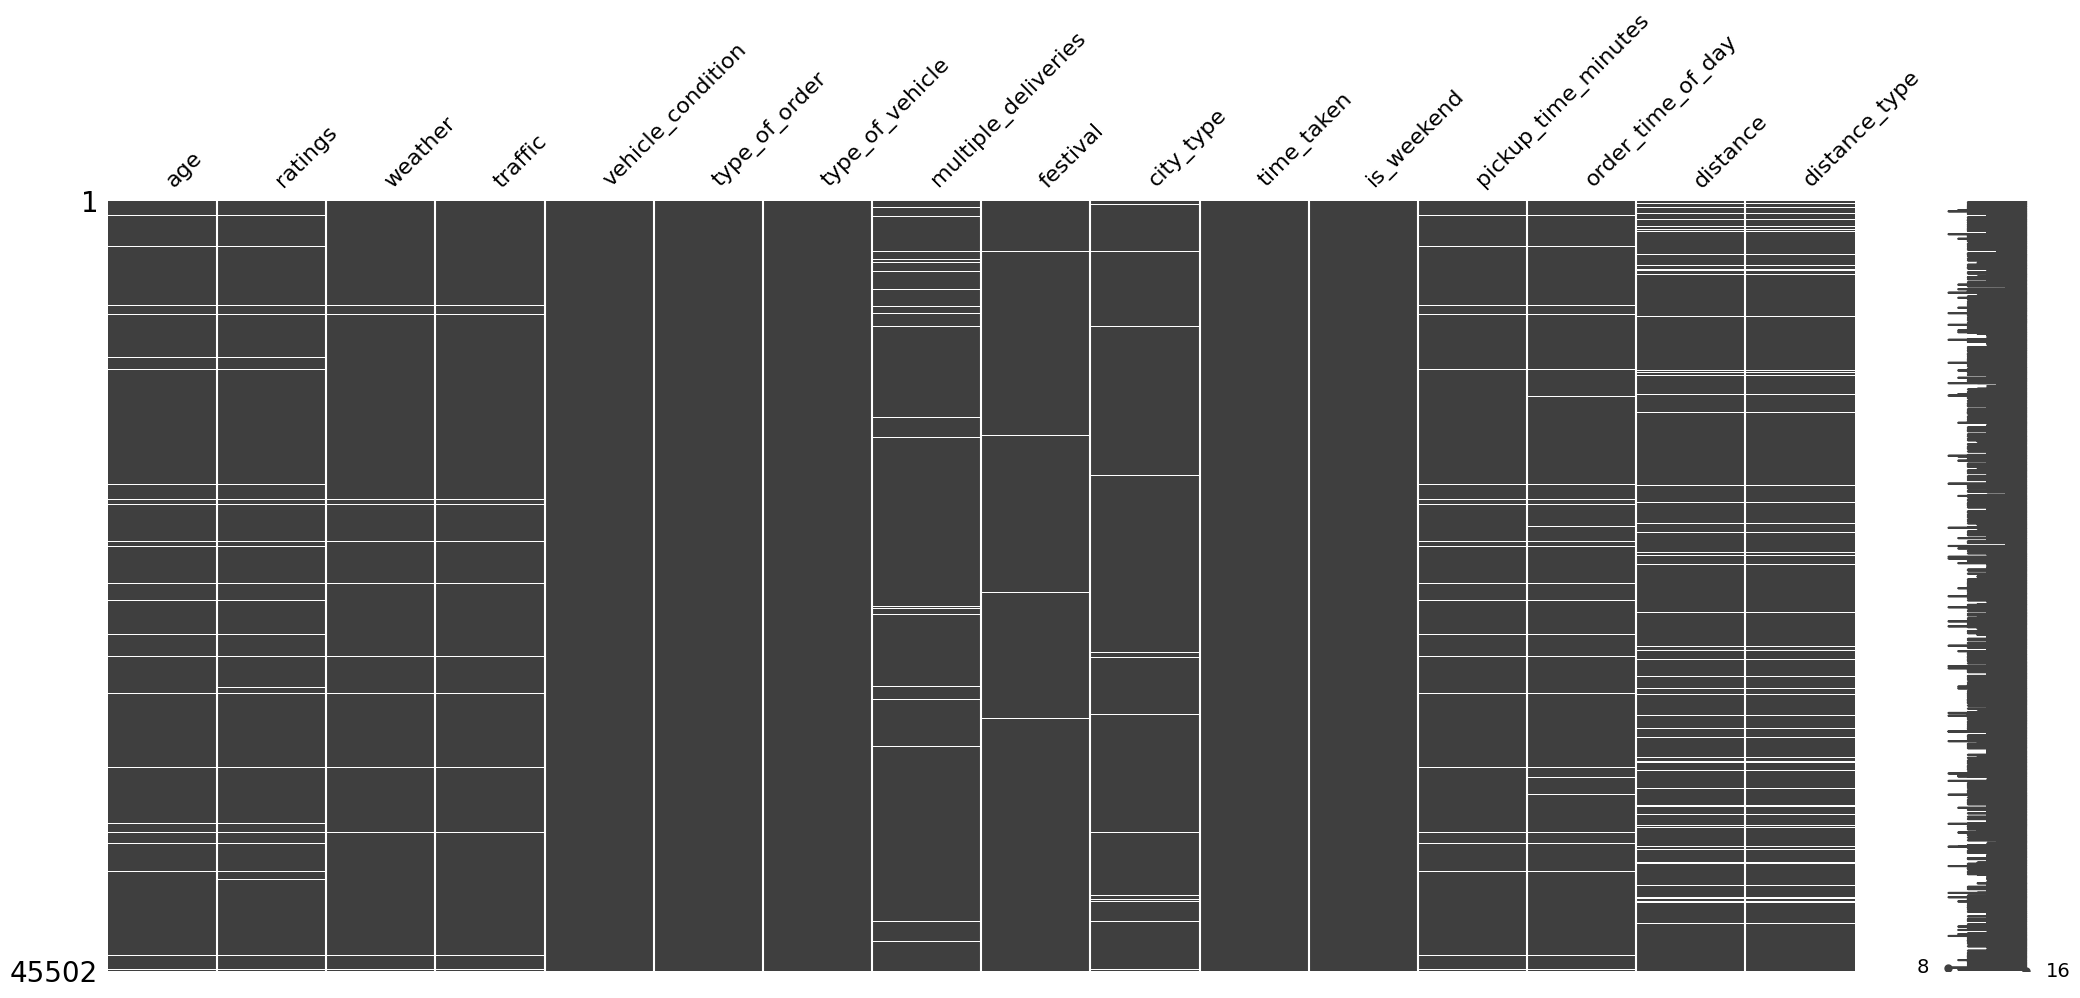

In [13]:
import missingno as msno

msno.matrix(df)

In [14]:
# columns that have missing values

missing_cols = (
                    df
                    .isna()
                    .any(axis=0)
                    .loc[lambda x: x]
                    .index
                )

missing_cols

Index(['age', 'ratings', 'weather', 'traffic', 'multiple_deliveries',
       'festival', 'city_type', 'pickup_time_minutes', 'order_time_of_day',
       'distance', 'distance_type'],
      dtype='object')

# Drop Missing values

In [15]:
temp_df = df.copy().dropna()

In [16]:
# split into X and y

X = temp_df.drop(columns='time_taken')
y = temp_df['time_taken']

X

,age,ratings,weather,traffic,vehicle_condition,type_of_order,type_of_vehicle,multiple_deliveries,festival,city_type,is_weekend,pickup_time_minutes,order_time_of_day,distance,distance_type
0,37.0,4.9,sunny,high,2,snack,motorcycle,0.0,no,urban,1,15.0,morning,3.025149,short
1,34.0,4.5,stormy,jam,2,snack,scooter,1.0,no,metropolitian,0,5.0,evening,20.183530,very_long
2,23.0,4.4,sandstorms,low,0,drinks,motorcycle,1.0,no,urban,1,15.0,morning,1.552758,short
3,38.0,4.7,sunny,medium,0,buffet,motorcycle,1.0,no,metropolitian,0,10.0,evening,7.790401,medium
4,32.0,4.6,cloudy,high,1,snack,scooter,1.0,no,metropolitian,1,15.0,afternoon,6.210138,medium
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45496,35.0,4.2,windy,jam,2,drinks,motorcycle,1.0,no,metropolitian,0,10.0,night,16.600272,very_long
45497,30.0,4.8,windy,high,1,meal,motorcycle,0.0,no,metropolitian,0,10.0,morning,1.489846,short
45499,30.0,4.9,cloudy,low,1,drinks,scooter,0.0,no,metropolitian,0,15.0,night,4.657195,short
45500,20.0,4.7,cloudy,high,0,snack,motorcycle,1.0,no,metropolitian,0,5.0,afternoon,6.232393,medium


In [17]:
# train test split

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [18]:
print("The size of train data is",X_train.shape)
print("The shape of test data is",X_test.shape)

The size of train data is (30156, 15)
The shape of test data is (7539, 15)


In [19]:
# missing values in train data

X_train.isna().sum()

age                    0
ratings                0
weather                0
traffic                0
vehicle_condition      0
type_of_order          0
type_of_vehicle        0
multiple_deliveries    0
festival               0
city_type              0
is_weekend             0
pickup_time_minutes    0
order_time_of_day      0
distance               0
distance_type          0
dtype: int64

In [20]:
# transform target column

pt = PowerTransformer()

y_train_pt = pt.fit_transform(y_train.values.reshape(-1,1))
y_test_pt = pt.transform(y_test.values.reshape(-1,1))

In [21]:
missing_cols

Index(['age', 'ratings', 'weather', 'traffic', 'multiple_deliveries',
       'festival', 'city_type', 'pickup_time_minutes', 'order_time_of_day',
       'distance', 'distance_type'],
      dtype='object')

In [22]:
# percentage of rows in data having missing values

(
    X_train
    .isna()
    .any(axis=1)
    .mean()
    .round(2) * 100
)


np.float64(0.0)

# Pre-Processing Pipeline

In [23]:
num_cols = ["age","ratings","pickup_time_minutes","distance"]

nominal_cat_cols = ['weather',
                    'type_of_order',
                    'type_of_vehicle',
                    "festival",
                    "city_type",
                    "is_weekend",
                    "order_time_of_day"]

ordinal_cat_cols = ["traffic","distance_type"]

In [24]:
nominal_cat_cols

['weather',
 'type_of_order',
 'type_of_vehicle',
 'festival',
 'city_type',
 'is_weekend',
 'order_time_of_day']

In [25]:
X_train.isna().sum()

age                    0
ratings                0
weather                0
traffic                0
vehicle_condition      0
type_of_order          0
type_of_vehicle        0
multiple_deliveries    0
festival               0
city_type              0
is_weekend             0
pickup_time_minutes    0
order_time_of_day      0
distance               0
distance_type          0
dtype: int64

In [26]:
# # features to fill values with mode

# features_to_fill_mode = ['multiple_deliveries','festival','city_type']
# features_to_fill_missing = [col for col in nominal_cat_cols if col not in features_to_fill_mode]

# features_to_fill_missing

In [27]:
# # simple imputer to fill categorical vars with mode

# simple_imputer = ColumnTransformer(transformers=[
#     ("mode_imputer",SimpleImputer(strategy="most_frequent",add_indicator=True),features_to_fill_mode),
#     ("missing_imputer",SimpleImputer(strategy="constant",fill_value="missing",add_indicator=True),features_to_fill_missing)
# ],remainder="passthrough",n_jobs=-1,force_int_remainder_cols=False,verbose_feature_names_out=False)

# simple_imputer

In [28]:
# simple_imputer.fit_transform(X_train)

In [29]:
# simple_imputer.fit_transform(X_train).isna().sum()

In [30]:
# knn imputer

# knn_imputer = KNNImputer(n_neighbors=5)

In [31]:
# do basic preprocessing

num_cols = ["age","ratings","pickup_time_minutes","distance"]

nominal_cat_cols = ['weather','type_of_order',
                    'type_of_vehicle',"festival",
                    "city_type",
                    "is_weekend",
                    "order_time_of_day"]

ordinal_cat_cols = ["traffic","distance_type"]

In [32]:
# generate order for ordinal encoding

traffic_order = ["low","medium","high","jam"]

distance_type_order = ["short","medium","long","very_long"]

In [33]:
# unique categories the ordinal columns

for col in ordinal_cat_cols:
    print(col,X_train[col].unique())

traffic ['jam' 'medium' 'high' 'low']
distance_type ['medium' 'short' 'long' 'very_long']


In [34]:
# build a preprocessor

preprocessor = ColumnTransformer(transformers=[
    ("scale", MinMaxScaler(), num_cols),
    ("nominal_encode", OneHotEncoder(drop="first",handle_unknown="ignore",
                                     sparse_output=False), nominal_cat_cols),
    ("ordinal_encode", OrdinalEncoder(categories=[traffic_order,distance_type_order],
                                      encoded_missing_value=-999,
                                      handle_unknown="use_encoded_value",
                                      unknown_value=-1), ordinal_cat_cols)
],remainder="passthrough",n_jobs=-1,force_int_remainder_cols=False,verbose_feature_names_out=False)


preprocessor

,transformers,"[('scale', ...), ('nominal_encode', ...), ...]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,-1
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,False
,force_int_remainder_cols,False
,feature_range,"(0, ...)"
,copy,True
,clip,False


In [35]:
# build the pipeline

processing_pipeline = Pipeline(steps=[
                                # ("simple_imputer",simple_imputer),
                                ("preprocess",preprocessor)
                                # ("knn_imputer",knn_imputer)
                            ])

processing_pipeline

,steps,"[('preprocess', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('scale', ...), ('nominal_encode', ...), ...]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,-1
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,False


In [36]:
# do data preprocessing

X_train_trans = processing_pipeline.fit_transform(X_train)

X_test_trans = processing_pipeline.transform(X_test)

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/compose/_column_transformer.py:975: FutureWarning: The parameter `force_int_remainder_cols` is deprecated and will be removed in 1.9. It has no effect. Leave it to its default value to avoid this warning.
  warnings.warn(


In [37]:
X_train_trans

,age,ratings,pickup_time_minutes,distance,weather_fog,weather_sandstorms,weather_stormy,weather_sunny,weather_windy,type_of_order_drinks,...,city_type_semi-urban,city_type_urban,is_weekend_1,order_time_of_day_evening,order_time_of_day_morning,order_time_of_day_night,traffic,distance_type,vehicle_condition,multiple_deliveries
8708,0.473684,0.56,1.0,0.404165,0.0,0.0,0.0,1.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,1.0,3.0,1.0,0,2.0
25198,1.000000,0.76,0.0,0.154044,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0,1.0
34049,0.473684,0.80,0.5,0.002461,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1,0.0
25987,1.000000,0.92,1.0,0.460411,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0,1.0
37121,0.526316,0.76,0.5,0.243676,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20239,0.578947,0.92,0.5,0.451895,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,3.0,2.0,0,0.0
7590,0.052632,1.00,1.0,0.612270,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,1.0,2.0,1,1.0
13610,0.526316,0.92,0.0,0.322877,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1,0.0
1045,0.947368,0.96,0.5,0.004486,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0,1.0


In [38]:
%pip install optuna


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [39]:
from sklearn.ensemble import RandomForestRegressor
import optuna

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [40]:
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.model_selection import cross_val_score
from sklearn.compose import TransformedTargetRegressor

In [41]:
def objective(trial):
    with mlflow.start_run(nested=True):
        params = {
            "n_estimators": trial.suggest_int("n_estimators",10,500),
            "max_depth": trial.suggest_int("max_depth",1,30),
            "max_features": trial.suggest_categorical("max_features",[None,"sqrt","log2"]),
            "min_samples_split": trial.suggest_int("min_samples_split",2,10),
            "min_samples_leaf": trial.suggest_int("min_samples_leaf",1,10),
            "max_samples": trial.suggest_float("max_samples",0.5,1),
            "random_state": 42,
            "n_jobs": -1,
        }

        # log model parameters
        mlflow.log_params(params)

        # build the model
        rf = RandomForestRegressor(**params)
        model = TransformedTargetRegressor(regressor=rf,transformer=pt)

        # train the model
        model.fit(X_train_trans,y_train)

        # get the predictions
        y_pred_train = model.predict(X_train_trans)
        y_pred_test = model.predict(X_test_trans)


        # perform cross validation
        cv_score = cross_val_score(model,
                                X_train_trans,
                                y_train,
                                cv=5,
                                scoring="neg_mean_absolute_error",
                                n_jobs=-1)

        # mean score
        mean_score = -(cv_score.mean())

        # log avg cross val error
        mlflow.log_metric("cross_val_error",mean_score)

        return mean_score

In [42]:
from sklearn.compose import TransformedTargetRegressor

In [43]:
# create optuna study
study = optuna.create_study(direction="minimize")

with mlflow.start_run(run_name="best_model"):
    # optimize the objective function
    study.optimize(objective,n_trials=20,n_jobs=-1,show_progress_bar=True)

    # log the best parameters
    mlflow.log_params(study.best_params)

    # log the best score
    mlflow.log_metric("best_score",study.best_value)

    # train the model on best parameters
    best_rf = RandomForestRegressor(**study.best_params)

    best_rf.fit(X_train_trans,y_train_pt.values.ravel())

    # get the predictions
    y_pred_train = best_rf.predict(X_train_trans)
    y_pred_test = best_rf.predict(X_test_trans)

    # get the actual predictions values
    y_pred_train_org = pt.inverse_transform(y_pred_train.reshape(-1,1))
    y_pred_test_org = pt.inverse_transform(y_pred_test.reshape(-1,1))


    # perform cross validation
    model = TransformedTargetRegressor(regressor=best_rf,
                                        transformer=pt)


    scores = cross_val_score(model,
                         X_train_trans,
                         y_train,
                         scoring="neg_mean_absolute_error",
                         cv=5,n_jobs=-1)

    # log metrics
    mlflow.log_metric("training_error",mean_absolute_error(y_train,y_pred_train_org))
    mlflow.log_metric("test_error",mean_absolute_error(y_test,y_pred_test_org))
    mlflow.log_metric("training_r2",r2_score(y_train,y_pred_train_org))
    mlflow.log_metric("test_r2",r2_score(y_test,y_pred_test_org))
    mlflow.log_metric("cross_val",- scores.mean())

    # log the best model
    mlflow.sklearn.log_model(best_rf,artifact_path="model")

[I 2025-06-28 18:37:40,485] A new study created in memory with name: no-name-5f3f9a52-2dee-4e4c-ad7d-3766abe57ec7
  0%|                                                                     | 0/20 [00:00<?, ?it/s]

🏃 View run abundant-shark-49 at: https://dagshub.com/prathamshelke2903/Swiggy_Delivery_Time_Prediction.mlflow/#/experiments/4/runs/b1499318f2424735ac0ab3d4dad19ff5
🧪 View experiment at: https://dagshub.com/prathamshelke2903/Swiggy_Delivery_Time_Prediction.mlflow/#/experiments/4
🏃 View run abundant-wren-544 at: https://dagshub.com/prathamshelke2903/Swiggy_Delivery_Time_Prediction.mlflow/#/experiments/4/runs/8eadd6f4a797451885c55e30614165e6
🧪 View experiment at: https://dagshub.com/prathamshelke2903/Swiggy_Delivery_Time_Prediction.mlflow/#/experiments/4
🏃 View run learned-rat-576 at: https://dagshub.com/prathamshelke2903/Swiggy_Delivery_Time_Prediction.mlflow/#/experiments/4/runs/083567029c48477ca2300df77d429db6
🧪 View experiment at: https://dagshub.com/prathamshelke2903/Swiggy_Delivery_Time_Prediction.mlflow/#/experiments/4
🏃 View run capable-shark-63 at: https://dagshub.com/prathamshelke2903/Swiggy_Delivery_Time_Prediction.mlflow/#/experiments/4/runs/b390f7d73e194da8a6afcf64dc1b6ca5
🧪 

Best trial: 8. Best value: 3.2259:   5%|█▎                        | 1/20 [00:36<11:41, 36.94s/it]

[I 2025-06-28 18:38:17,972] Trial 8 finished with value: 3.2259035981173754 and parameters: {'n_estimators': 302, 'max_depth': 15, 'max_features': 'sqrt', 'min_samples_split': 8, 'min_samples_leaf': 1, 'max_samples': 0.692675433006213}. Best is trial 8 with value: 3.2259035981173754.


Best trial: 8. Best value: 3.2259:  10%|██▌                       | 2/20 [00:37<04:44, 15.82s/it]

[I 2025-06-28 18:38:19,017] Trial 0 finished with value: 3.2591293265992527 and parameters: {'n_estimators': 130, 'max_depth': 23, 'max_features': 'sqrt', 'min_samples_split': 7, 'min_samples_leaf': 5, 'max_samples': 0.64685392034963}. Best is trial 8 with value: 3.2259035981173754.
🏃 View run nosy-shrimp-258 at: https://dagshub.com/prathamshelke2903/Swiggy_Delivery_Time_Prediction.mlflow/#/experiments/4/runs/19183dc123a145a8b24f3112863d1062
🧪 View experiment at: https://dagshub.com/prathamshelke2903/Swiggy_Delivery_Time_Prediction.mlflow/#/experiments/4


Best trial: 8. Best value: 3.2259:  15%|███▉                      | 3/20 [00:44<03:13, 11.36s/it]

[I 2025-06-28 18:38:25,055] Trial 7 finished with value: 3.2459285233828803 and parameters: {'n_estimators': 32, 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_split': 4, 'min_samples_leaf': 3, 'max_samples': 0.6284344839891548}. Best is trial 8 with value: 3.2259035981173754.


Best trial: 8. Best value: 3.2259:  20%|█████▏                    | 4/20 [00:45<01:56,  7.28s/it]

[I 2025-06-28 18:38:26,079] Trial 6 finished with value: 3.9405903351989595 and parameters: {'n_estimators': 172, 'max_depth': 8, 'max_features': 'log2', 'min_samples_split': 6, 'min_samples_leaf': 6, 'max_samples': 0.9107377846174238}. Best is trial 8 with value: 3.2259035981173754.
🏃 View run zealous-toad-136 at: https://dagshub.com/prathamshelke2903/Swiggy_Delivery_Time_Prediction.mlflow/#/experiments/4/runs/9443ef84a94e4a08b849e54c2bfd3252
🧪 View experiment at: https://dagshub.com/prathamshelke2903/Swiggy_Delivery_Time_Prediction.mlflow/#/experiments/4


Best trial: 8. Best value: 3.2259:  25%|██████▌                   | 5/20 [00:52<01:47,  7.17s/it]

[I 2025-06-28 18:38:33,050] Trial 2 finished with value: 3.474444383812778 and parameters: {'n_estimators': 364, 'max_depth': 12, 'max_features': 'log2', 'min_samples_split': 6, 'min_samples_leaf': 3, 'max_samples': 0.6205404649610952}. Best is trial 8 with value: 3.2259035981173754.
🏃 View run unique-dog-426 at: https://dagshub.com/prathamshelke2903/Swiggy_Delivery_Time_Prediction.mlflow/#/experiments/4/runs/6eecd96b67b64be9830306d51e943cea
🧪 View experiment at: https://dagshub.com/prathamshelke2903/Swiggy_Delivery_Time_Prediction.mlflow/#/experiments/4
🏃 View run worried-gull-598 at: https://dagshub.com/prathamshelke2903/Swiggy_Delivery_Time_Prediction.mlflow/#/experiments/4/runs/ba95b1c12ec947e8bf7472e1a2102155
🧪 View experiment at: https://dagshub.com/prathamshelke2903/Swiggy_Delivery_Time_Prediction.mlflow/#/experiments/4
🏃 View run aged-rook-961 at: https://dagshub.com/prathamshelke2903/Swiggy_Delivery_Time_Prediction.mlflow/#/experiments/4/runs/ee82145ed1ba469f87c4d7882447554f
🧪

Best trial: 8. Best value: 3.2259:  30%|███████▊                  | 6/20 [01:01<01:49,  7.80s/it]

[I 2025-06-28 18:38:42,076] Trial 5 finished with value: 3.3073686997015033 and parameters: {'n_estimators': 413, 'max_depth': 16, 'max_features': 'log2', 'min_samples_split': 7, 'min_samples_leaf': 4, 'max_samples': 0.9371362367467841}. Best is trial 8 with value: 3.2259035981173754.
🏃 View run skittish-foal-540 at: https://dagshub.com/prathamshelke2903/Swiggy_Delivery_Time_Prediction.mlflow/#/experiments/4/runs/bb286db838844c4ea810eed9401745ca
🧪 View experiment at: https://dagshub.com/prathamshelke2903/Swiggy_Delivery_Time_Prediction.mlflow/#/experiments/4


Best trial: 8. Best value: 3.2259:  35%|█████████                 | 7/20 [01:05<01:29,  6.85s/it]

[I 2025-06-28 18:38:46,969] Trial 9 finished with value: 4.697991660850731 and parameters: {'n_estimators': 320, 'max_depth': 4, 'max_features': None, 'min_samples_split': 7, 'min_samples_leaf': 8, 'max_samples': 0.8822670449108674}. Best is trial 8 with value: 3.2259035981173754.


Best trial: 8. Best value: 3.2259:  40%|██████████▍               | 8/20 [01:06<00:59,  4.99s/it]

[I 2025-06-28 18:38:47,993] Trial 4 finished with value: 4.013259828266767 and parameters: {'n_estimators': 261, 'max_depth': 6, 'max_features': None, 'min_samples_split': 10, 'min_samples_leaf': 6, 'max_samples': 0.5601841333099673}. Best is trial 8 with value: 3.2259035981173754.


Best trial: 8. Best value: 3.2259:  45%|███████████▋              | 9/20 [01:09<00:44,  4.07s/it]

[I 2025-06-28 18:38:50,045] Trial 3 finished with value: 3.673691610216605 and parameters: {'n_estimators': 365, 'max_depth': 10, 'max_features': 'log2', 'min_samples_split': 9, 'min_samples_leaf': 7, 'max_samples': 0.664727927500701}. Best is trial 8 with value: 3.2259035981173754.


Best trial: 8. Best value: 3.2259:  50%|████████████▌            | 10/20 [01:13<00:40,  4.05s/it]

[I 2025-06-28 18:38:54,038] Trial 1 finished with value: 3.3908478137942355 and parameters: {'n_estimators': 492, 'max_depth': 21, 'max_features': 'log2', 'min_samples_split': 2, 'min_samples_leaf': 8, 'max_samples': 0.8129102916746024}. Best is trial 8 with value: 3.2259035981173754.
🏃 View run adorable-stag-729 at: https://dagshub.com/prathamshelke2903/Swiggy_Delivery_Time_Prediction.mlflow/#/experiments/4/runs/a051d65eff7548a098ba48bf92d7e849
🧪 View experiment at: https://dagshub.com/prathamshelke2903/Swiggy_Delivery_Time_Prediction.mlflow/#/experiments/4
🏃 View run intrigued-shrew-438 at: https://dagshub.com/prathamshelke2903/Swiggy_Delivery_Time_Prediction.mlflow/#/experiments/4/runs/a1855dd7658e40a6ac6d0f5f4a2d6987
🧪 View experiment at: https://dagshub.com/prathamshelke2903/Swiggy_Delivery_Time_Prediction.mlflow/#/experiments/4
🏃 View run funny-goose-350 at: https://dagshub.com/prathamshelke2903/Swiggy_Delivery_Time_Prediction.mlflow/#/experiments/4/runs/b0224f27f53f4706bba53b89d

Best trial: 8. Best value: 3.2259:  55%|█████████████▊           | 11/20 [01:41<01:45, 11.68s/it]

[I 2025-06-28 18:39:23,015] Trial 10 finished with value: 5.91316562846644 and parameters: {'n_estimators': 329, 'max_depth': 2, 'max_features': None, 'min_samples_split': 7, 'min_samples_leaf': 3, 'max_samples': 0.9928712282497452}. Best is trial 8 with value: 3.2259035981173754.


Best trial: 8. Best value: 3.2259:  60%|███████████████          | 12/20 [01:43<01:09,  8.72s/it]

[I 2025-06-28 18:39:24,971] Trial 11 finished with value: 3.320433426040249 and parameters: {'n_estimators': 217, 'max_depth': 26, 'max_features': 'sqrt', 'min_samples_split': 4, 'min_samples_leaf': 10, 'max_samples': 0.7653594313851391}. Best is trial 8 with value: 3.2259035981173754.
🏃 View run calm-squirrel-443 at: https://dagshub.com/prathamshelke2903/Swiggy_Delivery_Time_Prediction.mlflow/#/experiments/4/runs/e9d98b4f352c4de4bf1ebb35ba621c82
🧪 View experiment at: https://dagshub.com/prathamshelke2903/Swiggy_Delivery_Time_Prediction.mlflow/#/experiments/4


Best trial: 12. Best value: 3.18644:  65%|██████████████▉        | 13/20 [01:48<00:53,  7.60s/it]

[I 2025-06-28 18:39:29,980] Trial 12 finished with value: 3.1864396107237476 and parameters: {'n_estimators': 159, 'max_depth': 21, 'max_features': 'sqrt', 'min_samples_split': 4, 'min_samples_leaf': 3, 'max_samples': 0.9371424757331495}. Best is trial 12 with value: 3.1864396107237476.


Best trial: 12. Best value: 3.18644:  70%|████████████████       | 14/20 [01:50<00:35,  5.92s/it]

[I 2025-06-28 18:39:32,035] Trial 13 finished with value: 3.3321535259620716 and parameters: {'n_estimators': 285, 'max_depth': 19, 'max_features': 'log2', 'min_samples_split': 6, 'min_samples_leaf': 5, 'max_samples': 0.7602119386961901}. Best is trial 12 with value: 3.1864396107237476.


Best trial: 12. Best value: 3.18644:  75%|█████████████████▎     | 15/20 [01:53<00:25,  5.03s/it]

[I 2025-06-28 18:39:34,996] Trial 14 finished with value: 5.034939796024986 and parameters: {'n_estimators': 466, 'max_depth': 4, 'max_features': 'log2', 'min_samples_split': 6, 'min_samples_leaf': 1, 'max_samples': 0.8320134509640942}. Best is trial 12 with value: 3.1864396107237476.
🏃 View run tasteful-goose-633 at: https://dagshub.com/prathamshelke2903/Swiggy_Delivery_Time_Prediction.mlflow/#/experiments/4/runs/3f11d6c54b084482a29a2779e10b51fa
🧪 View experiment at: https://dagshub.com/prathamshelke2903/Swiggy_Delivery_Time_Prediction.mlflow/#/experiments/4
🏃 View run nimble-bat-207 at: https://dagshub.com/prathamshelke2903/Swiggy_Delivery_Time_Prediction.mlflow/#/experiments/4/runs/8b632d2647e845f382e6e9dcc6f58370
🧪 View experiment at: https://dagshub.com/prathamshelke2903/Swiggy_Delivery_Time_Prediction.mlflow/#/experiments/4


Best trial: 16. Best value: 3.17627:  80%|██████████████████▍    | 16/20 [02:02<00:24,  6.23s/it]

[I 2025-06-28 18:39:44,012] Trial 16 finished with value: 3.1762672735704416 and parameters: {'n_estimators': 218, 'max_depth': 30, 'max_features': 'sqrt', 'min_samples_split': 9, 'min_samples_leaf': 1, 'max_samples': 0.7452013315961113}. Best is trial 16 with value: 3.1762672735704416.
🏃 View run suave-crow-432 at: https://dagshub.com/prathamshelke2903/Swiggy_Delivery_Time_Prediction.mlflow/#/experiments/4/runs/a8a665c292a74555a4a0327ef666877b
🧪 View experiment at: https://dagshub.com/prathamshelke2903/Swiggy_Delivery_Time_Prediction.mlflow/#/experiments/4


Best trial: 16. Best value: 3.17627:  85%|███████████████████▌   | 17/20 [02:05<00:14,  4.97s/it]

[I 2025-06-28 18:39:46,060] Trial 17 finished with value: 3.177646580237453 and parameters: {'n_estimators': 195, 'max_depth': 30, 'max_features': 'sqrt', 'min_samples_split': 9, 'min_samples_leaf': 1, 'max_samples': 0.7360053139660674}. Best is trial 16 with value: 3.1762672735704416.
🏃 View run kindly-lark-986 at: https://dagshub.com/prathamshelke2903/Swiggy_Delivery_Time_Prediction.mlflow/#/experiments/4/runs/38e903c7e960404e9a623daf386b4463
🧪 View experiment at: https://dagshub.com/prathamshelke2903/Swiggy_Delivery_Time_Prediction.mlflow/#/experiments/4
🏃 View run rogue-donkey-141 at: https://dagshub.com/prathamshelke2903/Swiggy_Delivery_Time_Prediction.mlflow/#/experiments/4/runs/94f3dacf14214fb0bd2fffca8564c30f
🧪 View experiment at: https://dagshub.com/prathamshelke2903/Swiggy_Delivery_Time_Prediction.mlflow/#/experiments/4


Best trial: 18. Best value: 3.17552:  90%|████████████████████▋  | 18/20 [02:08<00:08,  4.37s/it]

[I 2025-06-28 18:39:49,044] Trial 18 finished with value: 3.1755154036984172 and parameters: {'n_estimators': 197, 'max_depth': 26, 'max_features': 'sqrt', 'min_samples_split': 9, 'min_samples_leaf': 1, 'max_samples': 0.7393730584321954}. Best is trial 18 with value: 3.1755154036984172.


Best trial: 15. Best value: 3.08791:  95%|█████████████████████▊ | 19/20 [02:09<00:03,  3.37s/it]

[I 2025-06-28 18:39:50,082] Trial 15 finished with value: 3.0879123057777456 and parameters: {'n_estimators': 350, 'max_depth': 18, 'max_features': None, 'min_samples_split': 6, 'min_samples_leaf': 4, 'max_samples': 0.6851344917475506}. Best is trial 15 with value: 3.0879123057777456.


Best trial: 15. Best value: 3.08791: 100%|███████████████████████| 20/20 [02:10<00:00,  6.50s/it]


[I 2025-06-28 18:39:51,109] Trial 19 finished with value: 3.1795944997752654 and parameters: {'n_estimators': 196, 'max_depth': 27, 'max_features': 'sqrt', 'min_samples_split': 9, 'min_samples_leaf': 1, 'max_samples': 0.7563048322810388}. Best is trial 15 with value: 3.0879123057777456.


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2742: UserWarning: X has feature names, but PowerTransformer was fitted without feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2742: UserWarning: X has feature names, but PowerTransformer was fitted without feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2742: UserWarning: X has feature names, but PowerTransformer was fitted without feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2742: UserWarning: X has feature names, but PowerTransformer was fitted without feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2742: UserWarnin

🏃 View run best_model at: https://dagshub.com/prathamshelke2903/Swiggy_Delivery_Time_Prediction.mlflow/#/experiments/4/runs/f47871d900604a60811a02a86007a56c
🧪 View experiment at: https://dagshub.com/prathamshelke2903/Swiggy_Delivery_Time_Prediction.mlflow/#/experiments/4


KeyboardInterrupt: 

In [45]:
study.best_params

{'n_estimators': 350,
 'max_depth': 18,
 'max_features': None,
 'min_samples_split': 6,
 'min_samples_leaf': 4,
 'max_samples': 0.6851344917475506}

In [46]:
study.best_value

3.0879123057777456

In [47]:
study.best_trials

[FrozenTrial(number=15, state=1, values=[3.0879123057777456], datetime_start=datetime.datetime(2025, 6, 28, 18, 38, 42, 79560), datetime_complete=datetime.datetime(2025, 6, 28, 18, 39, 50, 82484), params={'n_estimators': 350, 'max_depth': 18, 'max_features': None, 'min_samples_split': 6, 'min_samples_leaf': 4, 'max_samples': 0.6851344917475506}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'n_estimators': IntDistribution(high=500, log=False, low=10, step=1), 'max_depth': IntDistribution(high=30, log=False, low=1, step=1), 'max_features': CategoricalDistribution(choices=(None, 'sqrt', 'log2')), 'min_samples_split': IntDistribution(high=10, log=False, low=2, step=1), 'min_samples_leaf': IntDistribution(high=10, log=False, low=1, step=1), 'max_samples': FloatDistribution(high=1.0, log=False, low=0.5, step=None)}, trial_id=15, value=None)]

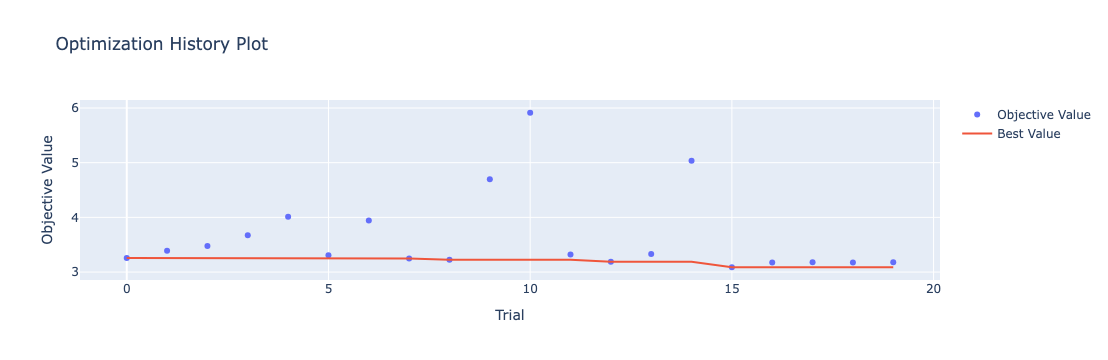

In [44]:
# optimization history plot

optuna.visualization.plot_optimization_history(study)

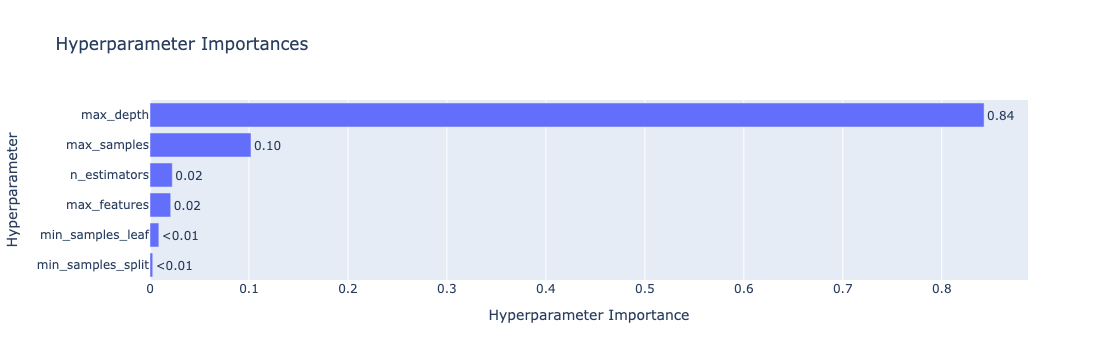

In [48]:
# plot hyperparameter importance plot

optuna.visualization.plot_param_importances(study)

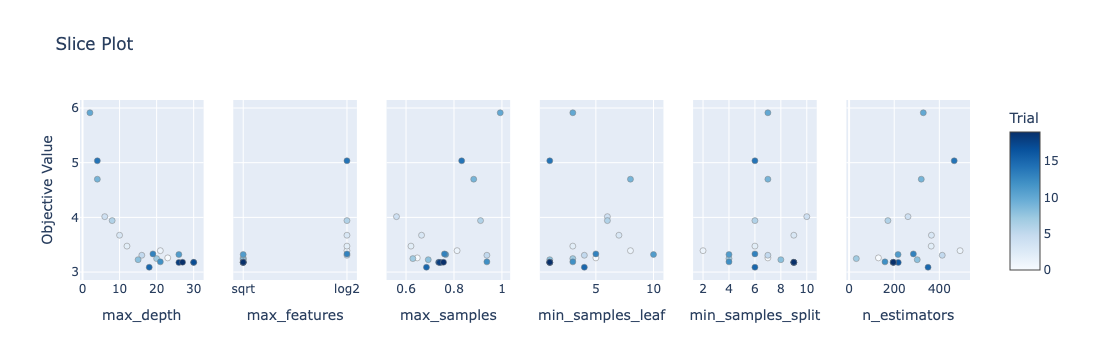

In [49]:
# slice plot

optuna.visualization.plot_slice(study)